In [14]:
# Analyse timestamps of fits files from a Seestar S50 session to show dropped frame stats

In [71]:
from astropy.io import fits
from pathlib import Path
from datetime import datetime as dt
import numpy as np

FITS_DIR = 'C:/SeeStar_images/Amphitrite/2024-01-19/Amphitrite-sub/'

EXP_TIME = 10.0 # exposure time
PROC_TIME = 1.0  #overhead for stacking
CYCLE_TIME = EXP_TIME + PROC_TIME  # approx elapsed time for a single imaging cycle of 10s

TICK_INTERVAL = 15 * 60  # tick spacing in timeline plot (in s)

In [16]:
# file handling

def read_timestamp(file):
    with fits.open(file) as hdul:
        hdr = hdul[0].header
        return hdr['DATE-OBS']
    
def read_all_timestamps(dir):
    fit_path = Path(dir)
    return [read_timestamp(p) for p in fit_path.glob('*.fit')]



In [42]:
# analysis

def timestamps_to_floats(ts, normalise = False):
    floats =  [dt.fromisoformat(t).timestamp() for t in ts]
    if normalise: 
        start = floats[0]
        floats = [f - start for f in floats]
    # return results as numpy array for further analysis
    return np.round(np.array(floats))

def timestamp_gaps(ts):
    return np.round(np.diff(ts/CYCLE_TIME)) - 1



In [43]:
timestamps = read_all_timestamps(FITS_DIR)

float_timestamps = timestamps_to_floats(timestamps)

gaps = timestamp_gaps(float_timestamps)

In [44]:
import collections

counter = collections.Counter(gaps)
counter

Counter({0.0: 85,
         3.0: 10,
         1.0: 47,
         2.0: 4,
         7.0: 2,
         9.0: 2,
         8.0: 1,
         6.0: 1,
         4.0: 2,
         5.0: 3,
         15.0: 1,
         10.0: 1})

In [64]:
# Basic stats for this run

nframes = len(timestamps)
skip_frames = int(sum(gaps))
frame_slots = skip_frames + nframes
total_time = dt.fromtimestamp(float_timestamps[-1] - float_timestamps[0]).strftime('%H:%M')

print('Total number of image slots: ', frame_slots)
print('Total number of image frames: ', nframes)
print('Skipped frames: ', skip_frames)
print(f'Capture efficiency: {nframes / frame_slots:.1%}')
print('Longest run of dropped frames: ', int(max(counter)))
print('Total imaging time: ', total_time)

Total number of image slots:  339
Total number of image frames:  160
Skipped frames:  179
Capture efficiency: 47.2%
Longest run of dropped frames:  15
Total imaging time:  01:03


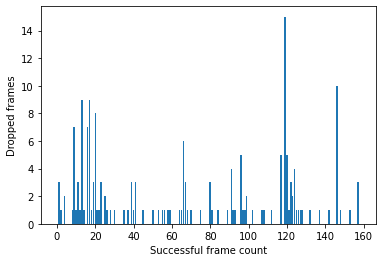

In [52]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator


# gap plot
indices = list(range(len(gaps)))
plt.bar(indices, gaps)
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0d'))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Successful frame count')
plt.ylabel('Dropped frames')
plt.savefig(FITS_DIR + 'frame_gaps.png', format = 'png')
plt.show()


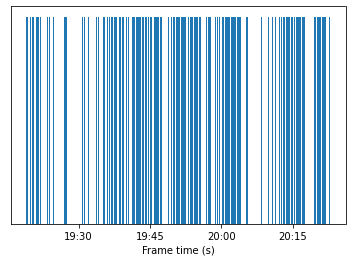

In [74]:
# linear plot

import matplotlib.ticker as ticker 

def label_format(ts, pos):
    return dt.fromtimestamp(ts).strftime('%H:%M')


plt.bar(float_timestamps, 1, CYCLE_TIME)
ax = plt.gca()
ax.get_yaxis().set_visible(False)
ax.xaxis.set_major_locator(ticker.MultipleLocator(TICK_INTERVAL))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(label_format))
plt.xlabel('Frame time (s)')
plt.savefig(FITS_DIR + 'frame_timings.png', format = 'png')
plt.show()
